# Project Data Science

This dataset contains information on job candidates applying for data science roles. It includes demographic details, education background, work experience, and training hours. The target variable indicates whether a candidate is looking for a new job (1) or not (0).

### Hypothesis  "Higher Experience Leads to Higher Job Seeking Rate"
                "Candidates from Developed Cities Have More Job Opportunities"
                "STEM Majors Are More Likely to Get Jobs"
                "More Training Hours Improve Job Chances"
                "Company Type Affects Job Seeking Rate"

### Stakeholder: Alex Wagner
Role: Job Market Analyst
Background:
Alex Wagner is a data-driven recruitment strategist working in the tech industry. He is responsible for analyzing job market trends, identifying skill gaps, and providing insights into hiring patterns. With years of experience in HR analytics, he wants to understand how factors like education, experience, and training hours impact job-seeking success.
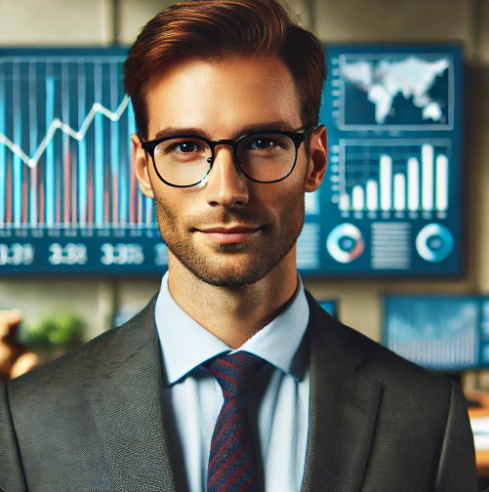

In [1]:
# Load the libraries
%pip install scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

Note: you may need to restart the kernel to use updated packages.


In [2]:
# load the data
df = pd.read_csv('./data/data_science_job.csv')

In [3]:
# Display first few rows
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,52.0,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,20.0,50-99,Funded Startup,8.0,0.0


In [4]:
# Check basic information
df.info()

# Check for missing values
df.isnull().sum()

# Check unique values in categorical columns
df.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


enrollee_id               19158
city                        123
city_development_index       93
gender                        3
relevent_experience           2
enrolled_university           3
education_level               5
major_discipline              6
experience                   21
company_size                  8
company_type                  6
training_hours              241
target                        2
dtype: int64

In [5]:
# Drop the columns
df.gender.unique()


array(['Male', nan, 'Female', 'Other'], dtype=object)

In [6]:
# Drop the columns
df.gender.value_counts()["Other"]

np.int64(191)

In [7]:
df = df[df["gender"]!="Other"]

### Convert categorical columns to numerical values

In [8]:
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
df['relevent_experience'] = df['relevent_experience'].map({'Has relevent experience': 1, 'No relevent experience': 0})

##  Data Cleaning
### Handling missing values and incorrect formats.

In [9]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Fill missing numerical values with the median
df.fillna(df.median(numeric_only=True), inplace=True)

# Fill missing categorical values with the most frequent category
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="most_frequent")
df[df.select_dtypes(include=['object']).columns] = imputer.fit_transform(df.select_dtypes(include=['object']))

# Confirm no missing values remain
print("Missing values after cleaning:\n", df.isnull().sum())


Missing values:
 enrollee_id                  0
city                         0
city_development_index     477
gender                    4508
relevent_experience          0
enrolled_university        373
education_level            451
major_discipline          2765
experience                  62
company_size              5859
company_type              6057
training_hours             754
target                       0
dtype: int64
Missing values after cleaning:
 enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
training_hours            0
target                    0
dtype: int64


### Encode Categorical Variables

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}  # Store encoders for future reference
categorical_columns = ['city', 'enrolled_university', 'education_level', 'major_discipline', 'company_type']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save the encoder for later

### Define Features (X) and Target (Y)

In [11]:
# Define X (features) and Y (target)
X = df.drop(columns=['target'])  # Remove target column from features
y = df['target']  # Define target variable

### Normalize the Data (Scale Features to 0-1)

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X[X.select_dtypes(include=['number']).columns] = scaler.fit_transform(X[X.select_dtypes(include=['number']).columns])


## Exploratory Data Analysis (EDA)


### 1.Gender Distribution

C:\Users\gulca\AppData\Local\Temp\ipykernel_20180\116997873.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='gender', data=df, palette="viridis")


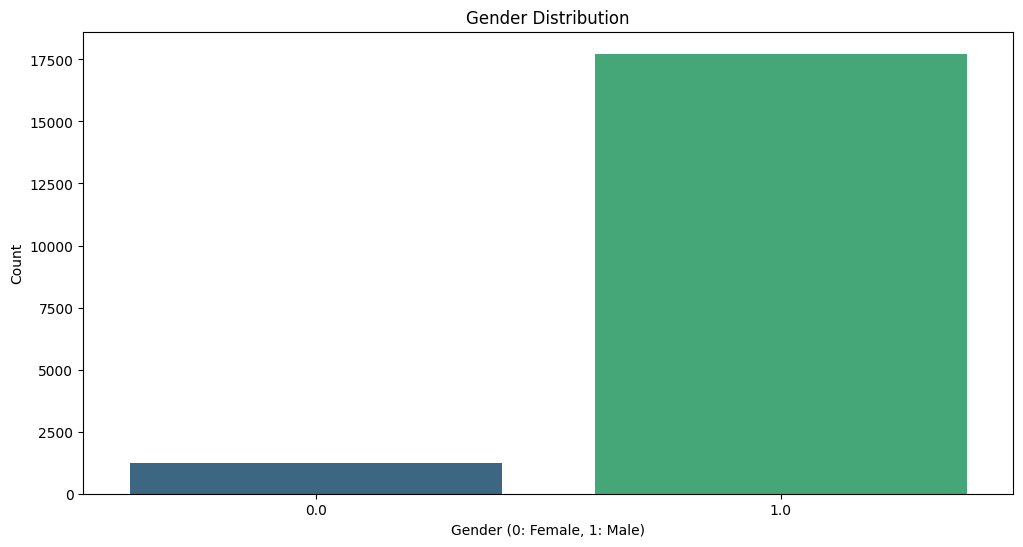

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(x='gender', data=df, palette="viridis")
plt.title("Gender Distribution")
plt.xlabel("Gender (0: Female, 1: Male)")
plt.ylabel("Count")
plt.show()

### 2. Education Level Distribution

C:\Users\gulca\AppData\Local\Temp\ipykernel_20180\2420632074.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='education_level', data=df, palette="coolwarm", order=df['education_level'].value_counts().index)


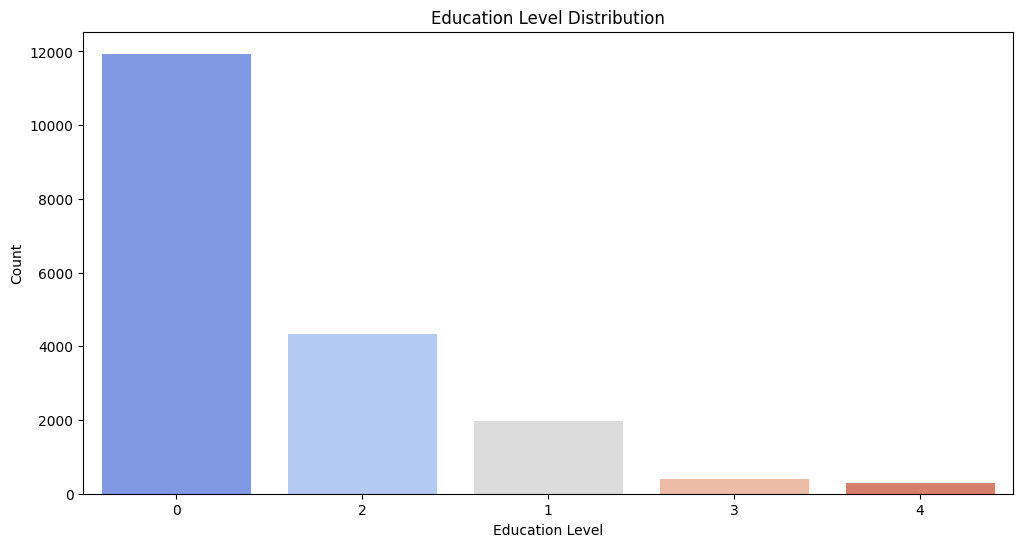

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(x='education_level', data=df, palette="coolwarm", order=df['education_level'].value_counts().index)
plt.title("Education Level Distribution")
plt.xlabel("Education Level")
plt.ylabel("Count")
plt.show()

### 3. Company Size Distribution

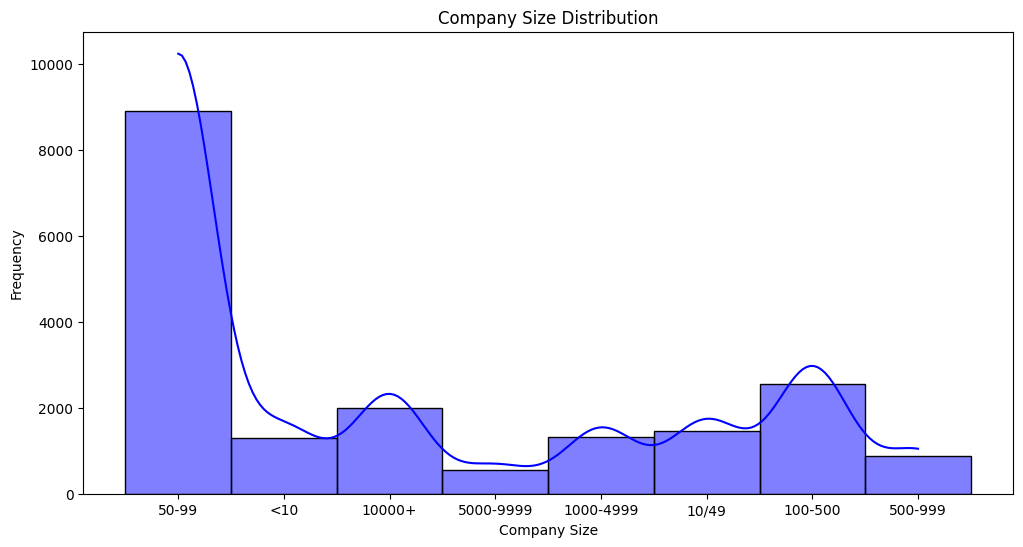

In [15]:
plt.figure(figsize=(12, 6))
sns.histplot(df['company_size'], bins=15, kde=True, color='blue')
plt.title("Company Size Distribution")
plt.xlabel("Company Size")
plt.ylabel("Frequency")
plt.show()

### 4. Experience Years Distribution

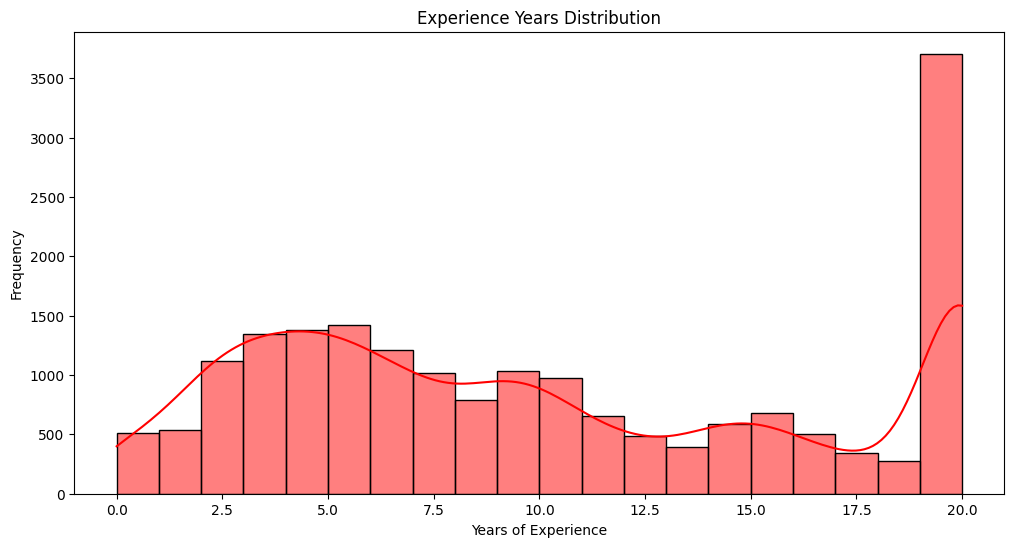

In [16]:
plt.figure(figsize=(12, 6))
sns.histplot(df['experience'], bins=20, kde=True, color='red')
plt.title("Experience Years Distribution")
plt.xlabel("Years of Experience")
plt.ylabel("Frequency")
plt.show()

### 5. Job Seekers by Education Level

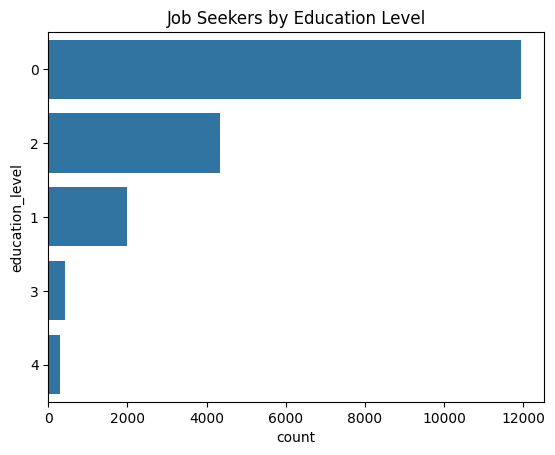

In [17]:
# Job Seekers by Education Level
sns.countplot(data=df, y="education_level", order=df["education_level"].value_counts().index)
plt.title("Job Seekers by Education Level")
plt.show()

### 6. Relationship Between Company Size and Experience

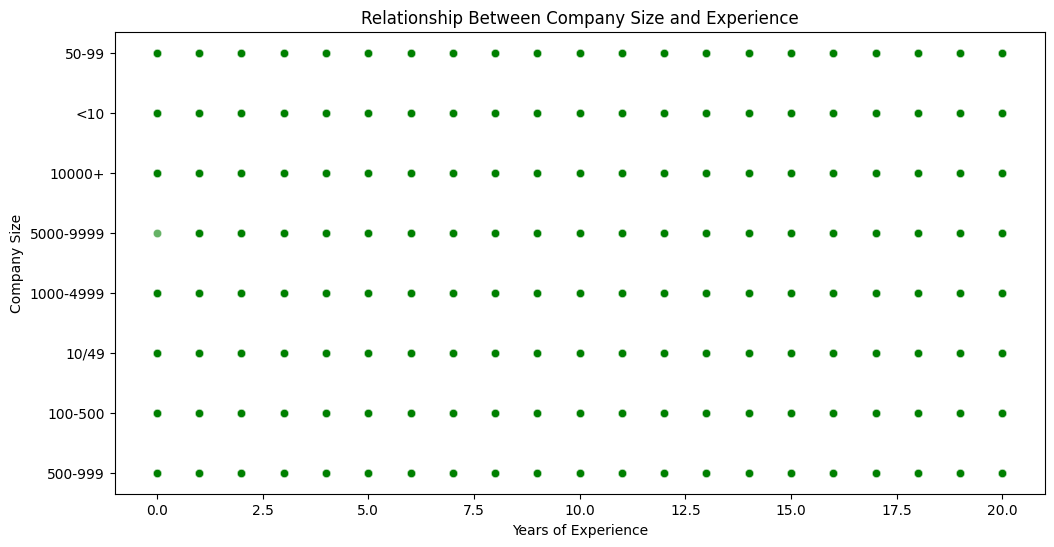

In [18]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='experience', y='company_size', data=df, alpha=0.6, color='green')
plt.title("Relationship Between Company Size and Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Company Size")
plt.show()

### 7. Job Seeking and Experience Relationship

C:\Users\gulca\AppData\Local\Temp\ipykernel_20180\956028379.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='experience', data=df, palette="plasma")


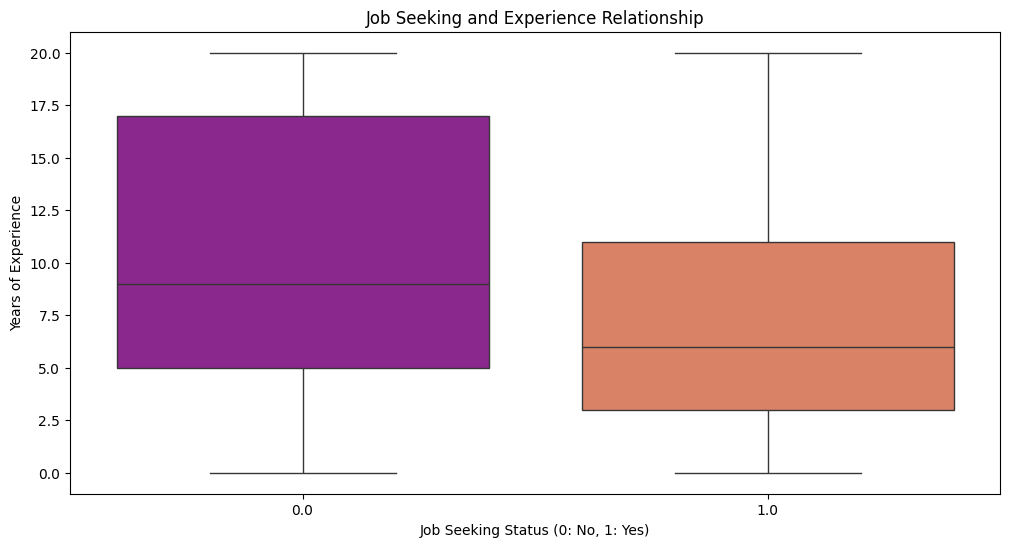

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='target', y='experience', data=df, palette="plasma")
plt.title("Job Seeking and Experience Relationship")
plt.xlabel("Job Seeking Status (0: No, 1: Yes)")
plt.ylabel("Years of Experience")
plt.show()

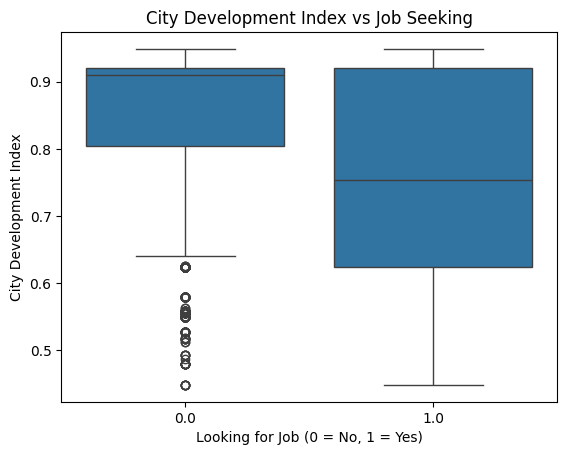

In [20]:
# City Development Index vs. Job Seeking
sns.boxplot(data=df, x="target", y="city_development_index")
plt.title("City Development Index vs Job Seeking")
plt.xlabel("Looking for Job (0 = No, 1 = Yes)")
plt.ylabel("City Development Index")
plt.show()

### Convert company_size using log transformation and scaling

In [21]:
company_size_mapping = {
    '<10': 5,
    '10-49': 30,
    '50-99': 75,
    '100-500': 300,
    '500-999': 750,
    '1000-4999': 3000,
    '5000-9999': 7500,
    '10000+': 15000
}
df['company_size'] = df['company_size'].map(company_size_mapping)

### Apply log transformation

In [22]:
df['company_size'] = np.log1p(df['company_size'])

### Scale company_size to 0-1 range

In [23]:
from sklearn.preprocessing import MinMaxScaler  # ✅ Import the missing library

# Initialize scaler
scaler = MinMaxScaler()

# Apply scaling to the 'company_size' column
df[['company_size']] = scaler.fit_transform(df[['company_size']])

# Check the result
print(df[['company_size']].head())


   company_size
0      0.324506
1      0.324506
2      0.324506
3      0.324506
4      0.324506


### Handle missing values

In [24]:
from sklearn.impute import SimpleImputer  # ✅ Import the missing library

# Initialize imputer with the most frequent strategy
imputer = SimpleImputer(strategy='most_frequent')

# Apply imputation to the dataset
df[:] = imputer.fit_transform(df)

# Check if missing values are handled
print(df.isnull().sum())  # Should print 0 for all columns


enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
training_hours            0
target                    0
dtype: int64


### Encode categorical variables

In [25]:
from sklearn.preprocessing import LabelEncoder

# Define categorical columns
categorical_columns = ['city', 'enrolled_university', 'education_level', 'major_discipline', 'company_type']

# Initialize a dictionary to store encoders
label_encoders = {}

# Apply Label Encoding to each categorical column
for col in categorical_columns:
    le = LabelEncoder()

    # Handle missing values before encoding
    df[col] = df[col].fillna("Unknown")  # Replace NaN with 'Unknown'

    # Fit & transform the column
    df[col] = le.fit_transform(df[col])

    # Store the encoder for later use (e.g., inverse transformation)
    label_encoders[col] = le

# Check the first few rows after encoding
print(df.head())


   enrollee_id  city  city_development_index  gender  relevent_experience  \
0         8949     5                   0.920     1.0                    1   
1        29725    77                   0.776     1.0                    0   
2        11561    64                   0.624     1.0                    0   
3        33241    14                   0.789     1.0                    0   
4          666    50                   0.767     1.0                    1   

   enrolled_university  education_level  major_discipline  experience  \
0                    2                0                 5        20.0   
1                    2                0                 5        15.0   
2                    0                0                 5         5.0   
3                    2                0                 1         0.0   
4                    2                2                 5        20.0   

   company_size  company_type  training_hours  target  
0      0.324506             5            3

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18967 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             18967 non-null  int64  
 1   city                    18967 non-null  int64  
 2   city_development_index  18967 non-null  float64
 3   gender                  18967 non-null  float64
 4   relevent_experience     18967 non-null  int64  
 5   enrolled_university     18967 non-null  int64  
 6   education_level         18967 non-null  int64  
 7   major_discipline        18967 non-null  int64  
 8   experience              18967 non-null  float64
 9   company_size            18967 non-null  float64
 10  company_type            18967 non-null  int64  
 11  training_hours          18967 non-null  float64
 12  target                  18967 non-null  float64
dtypes: float64(6), int64(7)
memory usage: 2.0 MB


In [27]:
df.describe()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
count,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000,18967.000000
mean,16864.799652,44.217378,0.830447,0.934729,0.721516,1.546686,0.690146,4.719355,9.934834,0.460462,4.488954,64.464227,0.249222
std,9603.857381,35.428691,0.122511,0.247010,0.448265,0.799346,0.995826,0.947953,6.493288,0.265169,1.297907,58.786029,0.432574
min,1.000000,0.000000,0.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8554.500000,5.000000,0.743000,1.000000,0.000000,1.000000,0.000000,5.000000,4.000000,0.324506,5.000000,24.000000,0.000000
50%,16980.000000,48.000000,0.903000,1.000000,1.000000,2.000000,0.000000,5.000000,9.000000,0.324506,5.000000,47.000000,0.000000
75%,25123.500000,64.000000,0.920000,1.000000,1.000000,2.000000,2.000000,5.000000,16.000000,0.558849,5.000000,86.000000,0.000000
max,33380.000000,122.000000,0.949000,1.000000,1.000000,2.000000,4.000000,5.000000,20.000000,1.000000,5.000000,336.000000,1.000000


In [28]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,8949,5,0.920,1.0,1,2,0,5,20.0,0.324506,5,36.0,1.0
1,29725,77,0.776,1.0,0,2,0,5,15.0,0.324506,5,47.0,0.0
2,11561,64,0.624,1.0,0,0,0,5,5.0,0.324506,5,83.0,0.0
3,33241,14,0.789,1.0,0,2,0,1,0.0,0.324506,5,52.0,1.0
4,666,50,0.767,1.0,1,2,2,5,20.0,0.324506,1,8.0,0.0


In [29]:
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder with the correct parameter
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Use sparse_output instead of sparse

# Apply encoding to categorical columns
encoded_features = encoder.fit_transform(X[categorical_columns])

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_columns))

# Drop original categorical columns and merge new ones
X = X.drop(columns=categorical_columns).reset_index(drop=True)
X = pd.concat([X, encoded_df], axis=1)

# Check if all columns are now numeric
print(X.dtypes)


enrollee_id                        float64
city_development_index             float64
gender                             float64
relevent_experience                float64
experience                         float64
                                    ...   
company_type_0.2                   float64
company_type_0.4                   float64
company_type_0.6000000000000001    float64
company_type_0.8                   float64
company_type_1.0                   float64
Length: 150, dtype: object


### Train-Test Split
Before training models, we split the dataset into training (80%) and testing (20%).

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [31]:
for col in X_train.columns:
    # Check for non-numeric values
    non_numeric_values = X_train[col][~X_train[col].apply(lambda x: isinstance(x, (int, float)))]
    if not non_numeric_values.empty:
        print(f"Column '{col}' has non-numeric values: {non_numeric_values.unique()}")

Column 'company_size' has non-numeric values: ['<10' '50-99' '5000-9999' '10/49' '10000+' '100-500' '1000-4999'
 '500-999']


In [32]:
# Convert to numeric and handle invalid values
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')           
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [33]:
print("Missing values in X_train:", X_train.isnull().sum().sum())
print("Missing values in X_test:", X_test.isnull().sum().sum())

Missing values in X_train: 0
Missing values in X_test: 0


In [34]:
print("X_train dtypes:", X_train.dtypes)
print("X_test dtypes:", X_test.dtypes)

X_train dtypes: enrollee_id                        float64
city_development_index             float64
gender                             float64
relevent_experience                float64
experience                         float64
                                    ...   
company_type_0.2                   float64
company_type_0.4                   float64
company_type_0.6000000000000001    float64
company_type_0.8                   float64
company_type_1.0                   float64
Length: 150, dtype: object
X_test dtypes: enrollee_id                        float64
city_development_index             float64
gender                             float64
relevent_experience                float64
experience                         float64
                                    ...   
company_type_0.2                   float64
company_type_0.4                   float64
company_type_0.6000000000000001    float64
company_type_0.8                   float64
company_type_1.0                   floa

In [35]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (15173, 150)
X_test shape: (3794, 150)
y_train shape: (15173,)
y_test shape: (3794,)


In [36]:
print(X_train.dtypes)

enrollee_id                        float64
city_development_index             float64
gender                             float64
relevent_experience                float64
experience                         float64
                                    ...   
company_type_0.2                   float64
company_type_0.4                   float64
company_type_0.6000000000000001    float64
company_type_0.8                   float64
company_type_1.0                   float64
Length: 150, dtype: object


In [37]:
for col in X_train.columns:
    if X_train[col].dtype == 'float64':
        # Check for non-numeric values
        non_numeric_values = X_train[col][~X_train[col].apply(lambda x: isinstance(x, (int, float)))]
        if not non_numeric_values.empty:
            print(f"Column '{col}' has non-numeric values: {non_numeric_values.unique()}")

In [38]:
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [39]:
print("Unique values in y_train:", np.unique(y_train))
print("Unique values in y_test:", np.unique(y_test))

Unique values in y_train: [0 1]
Unique values in y_test: [0 1]


### Train and evaluate models

In [41]:
%pip install xgboost

from sklearn.neighbors import KNeighborsClassifier  # KNN
from sklearn.svm import SVC  # SVM
from sklearn.naive_bayes import GaussianNB  # Naive Bayes
from sklearn.ensemble import RandomForestClassifier  # Random Forest
from xgboost import XGBClassifier  # XGBoost
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize classifiers
knn = KNeighborsClassifier()
svm = SVC(probability=True)  # Enable probability for ROC-AUC if needed
nb = GaussianNB()
rf = RandomForestClassifier(random_state=42)
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

classifiers = {
    "KNN": knn,
    "SVM": svm,
    "Naive Bayes": nb,
    "Random Forest": rf,
    "XGBoost": xgb
}

results = {}

for name, clf in classifiers.items():
    print(f"Training {name}...")
    
    # Train the model
    clf.fit(X_train, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)
    
    # Store results
    results[name] = accuracy
    # Print results
for name, accuracy in results.items():
    print(f"{name}: {accuracy:.4f}")
    print(X_train.dtypes)

Note: you may need to restart the kernel to use updated packages.
Training KNN...
KNN Accuracy: 0.7517
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      2876
           1       0.48      0.39      0.43       918

    accuracy                           0.75      3794
   macro avg       0.65      0.63      0.64      3794
weighted avg       0.74      0.75      0.74      3794

[[2497  379]
 [ 563  355]]
--------------------------------------------------
Training SVM...
SVM Accuracy: 0.7807
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      2876
           1       0.56      0.42      0.48       918

    accuracy                           0.78      3794
   macro avg       0.70      0.66      0.67      3794
weighted avg       0.76      0.78      0.77      3794

[[2580  296]
 [ 536  382]]
--------------------------------------------------
Training Naive Bayes...
Naive Bayes Accuracy: 0.36

c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:55:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [42]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=2876/918)


In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation accuracy: 0.7771
Test Accuracy: 0.7794


In [46]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(20))  # Top 20 important features

                      Feature  Importance
0                 enrollee_id    0.235288
6              training_hours    0.211452
4                  experience    0.128069
1      city_development_index    0.101326
71    city_0.5245901639344263    0.052694
3         relevent_experience    0.020648
2                      gender    0.012043
130   enrolled_university_0.0    0.011857
133       education_level_0.0    0.010960
132   enrolled_university_1.0    0.010878
149          company_type_1.0    0.009307
12   city_0.04098360655737705    0.007718
135       education_level_0.5    0.007710
143      major_discipline_1.0    0.007405
134      education_level_0.25    0.006619
55   city_0.39344262295081966    0.005748
148          company_type_0.8    0.005641
131   enrolled_university_0.5    0.005478
20   city_0.10655737704918034    0.004752
56    city_0.4016393442622951    0.004656


In [47]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")

c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:07:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learn

Best parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300}
Best cross-validation accuracy: 0.7800
Test Accuracy: 0.7833


In [48]:
from sklearn.metrics import roc_auc_score

y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probability of class 1
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.7398


In [49]:
# Handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train and evaluate models
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("-" * 50)

Training KNN...
KNN Accuracy: 0.6368
              precision    recall  f1-score   support

           0       0.85      0.63      0.73      2876
           1       0.36      0.65      0.46       918

    accuracy                           0.64      3794
   macro avg       0.60      0.64      0.59      3794
weighted avg       0.73      0.64      0.66      3794

[[1821 1055]
 [ 323  595]]
--------------------------------------------------
Training SVM...
SVM Accuracy: 0.7364
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      2876
           1       0.47      0.63      0.54       918

    accuracy                           0.74      3794
   macro avg       0.67      0.70      0.68      3794
weighted avg       0.77      0.74      0.75      3794

[[2215  661]
 [ 339  579]]
--------------------------------------------------
Training Naive Bayes...
Naive Bayes Accuracy: 0.3751
              precision    recall  f1-score   support

        

c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:15:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.7580
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      2876
           1       0.50      0.51      0.50       918

    accuracy                           0.76      3794
   macro avg       0.67      0.67      0.67      3794
weighted avg       0.76      0.76      0.76      3794

[[2410  466]
 [ 452  466]]
--------------------------------------------------


### Visualisation

### 1. Confusion Matrix
A confusion matrix helps visualize the performance of a classification model by showing the true positives, true negatives, false positives, and false negatives.

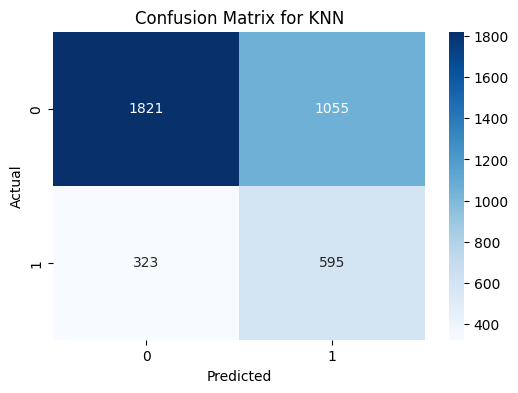

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example for KNN
y_pred_knn = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 2. ROC Curve
The ROC curve shows the trade-off between the true positive rate (sensitivity) and the false positive rate (1 - specificity) for different classification thresholds. The area under the curve (AUC) is a measure of model performance.

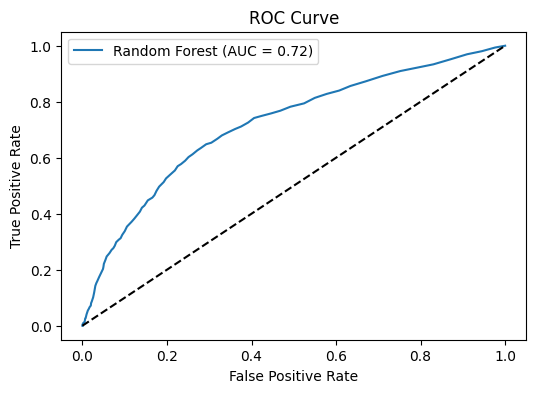

In [51]:
from sklearn.metrics import roc_curve, roc_auc_score

# Example for Random Forest
y_pred_proba_rf = rf.predict_proba(X_test)[:, 1]  # Probability of class 1
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_rf)
roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### 3. Precision-Recall Curve
The precision-recall curve is useful for imbalanced datasets. It shows the trade-off between precision and recall for different classification thresholds.

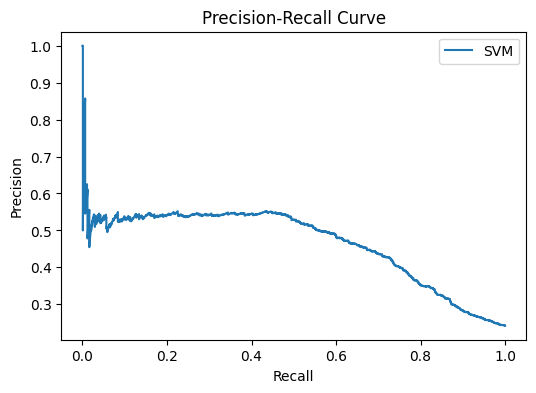

In [52]:
from sklearn.metrics import precision_recall_curve

# Example for SVM
y_pred_proba_svm = svm.predict_proba(X_test)[:, 1]  # Probability of class 1
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_svm)

# Plot Precision-Recall curve
plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label='SVM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

### 4. Feature Importance
<h3>For tree-based models like Random Forest and XGBoost, you can visualize the importance of each feature.
This feature importance plot visualizes the top 20 most influential features in predicting the target variable using the Random Forest model. 
It helps us understand which factors have the 
greatest impact on job-seeking success, 
allowing for better feature selection and interpretability of the model.</h3>

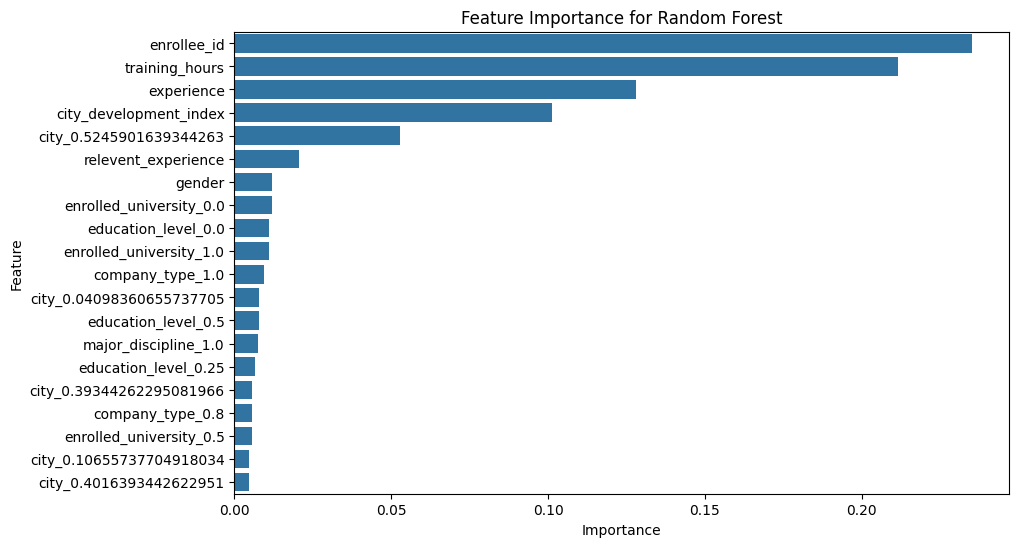

In [53]:
# Example for Random Forest
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))  # Top 20 features
plt.title('Feature Importance for Random Forest')
plt.show()

### 5. Class Distribution
Visualize the distribution of the target variable to understand the class imbalance.

C:\Users\gulca\AppData\Local\Temp\ipykernel_20180\1673338256.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='Set2')


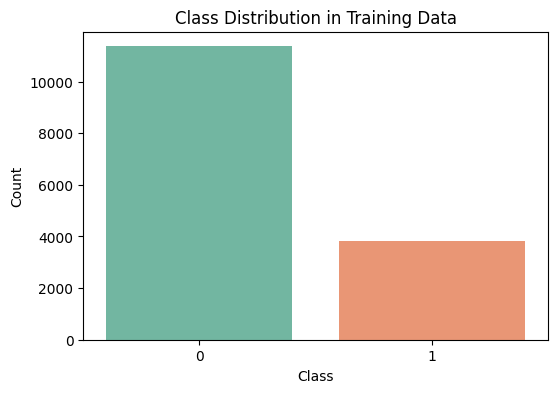

In [ ]:
# "target" (Binary: 1 = Actively looking for a job, 0 = Not looking)
# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, palette='Set2')
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

### 6. Correlation Heatmap
A correlation heatmap helps identify relationships between features. This is useful for feature selection and understanding multicollinearity.

This **correlation heatmap** visualizes the relationships between different numerical features in the dataset. It helps identify.
**strongly correlated features**, which can be useful for **feature selection** and
**avoiding multicollinearity** in machine learning models.

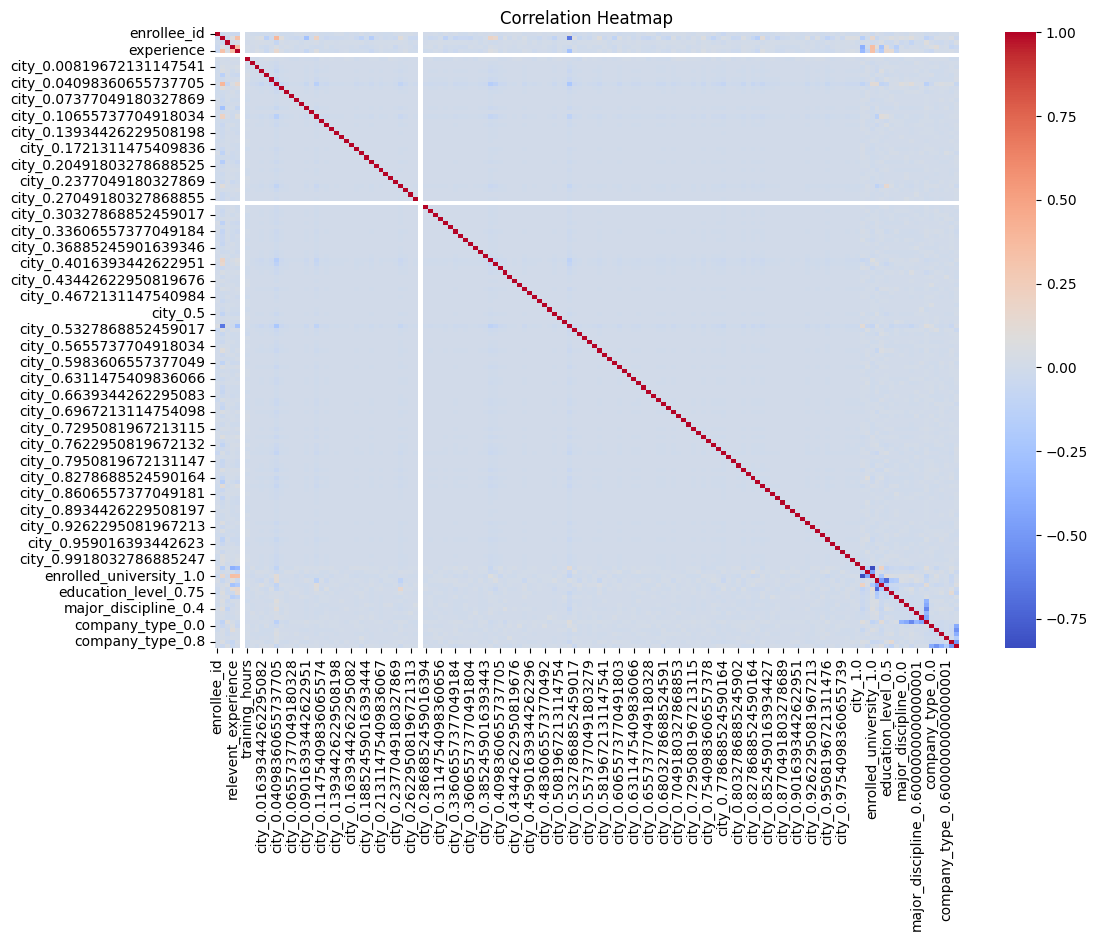

In [55]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()

### 7. Learning Curve
A learning curve shows how the model's performance (e.g., accuracy or loss) changes as the training dataset size increases. This helps diagnose overfitting or underfitting.

### This **learning curve visualization** shows how the **Random Forest model's accuracy** 
### evolves as the training set size increases. It helps us understand whether the model is **overfitting** 
### (high training score, low validation score) or **underfitting** (both scores low), guiding us in optimizing model complexity and dataset size.

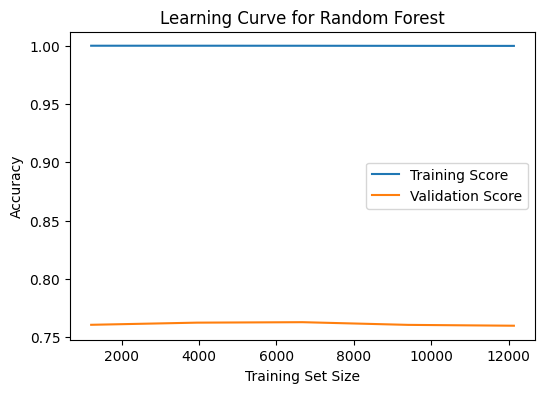

In [56]:
from sklearn.model_selection import learning_curve

# Example for Random Forest
train_sizes, train_scores, test_scores = learning_curve(rf, X_train, y_train, cv=5, scoring='accuracy')

# Plot learning curve
plt.figure(figsize=(6, 4))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validation Score')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Random Forest')
plt.legend()
plt.show()

### 8. Model Comparison
Compare the performance of different models using a bar plot.


### This bar plot compares the accuracy of different machine learning models used for job-seeking prediction. 
### It helps us identify which model performs best, with higher bars indicating better predictive accuracy, allowing for an informed decision on the most effective approach.

C:\Users\gulca\AppData\Local\Temp\ipykernel_20180\2321207469.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


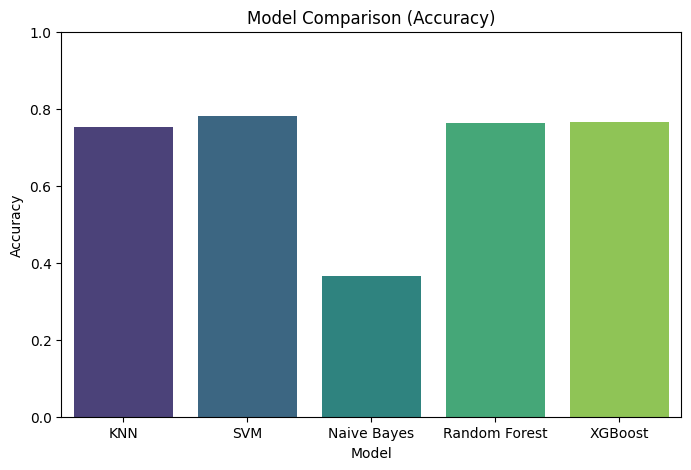

In [57]:
# Example: Compare accuracy of all models
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(8, 5))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Comparison (Accuracy)')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

### 9. Distribution of Predictions
Visualize the distribution of predicted probabilities for each class.

In [60]:
xgb.fit(X_train, y_train)

c:\Users\gulca\Documents\greenbootcamps\Data_science_job_data_set\.venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:23:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [61]:
y_pred_proba_xgb = xgb.predict_proba(X_test)[:, 1]  # Probability of class 1

### This histogram visualizes the distribution of predicted probabilities from the XGBoost model, showing how confident the model is in classifying job-seeking success. 
### A skewed distribution may indicate class imbalance or how well-separated the classes are, helping us assess the model's confidence in its predictions.

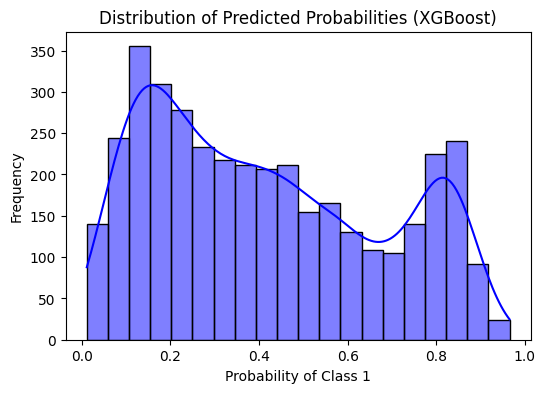

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.histplot(y_pred_proba_xgb, bins=20, kde=True, color='blue')
plt.title('Distribution of Predicted Probabilities (XGBoost)')
plt.xlabel('Probability of Class 1')
plt.ylabel('Frequency')
plt.show()

In [74]:
import joblib

# Save the preprocessing objects
joblib.dump(encoder, 'onehot_encoder.pkl')  # OneHotEncoder
joblib.dump(scaler, 'scaler.pkl')          # StandardScaler
joblib.dump(X_train.columns, 'training_columns.pkl')  # Column names of processed training data

['training_columns.pkl']

### 10. Pairplot for Feature Relationships
A pairplot helps visualize relationships between features and the target variable.
### The pairplot visualizes the relationships between the top 5 most important features in the dataset and their impact on the target variable (job-seeking success). It helps identify patterns, correlations, and potential separability between job seekers who secure jobs and those who do not, aiding in model interpretability.

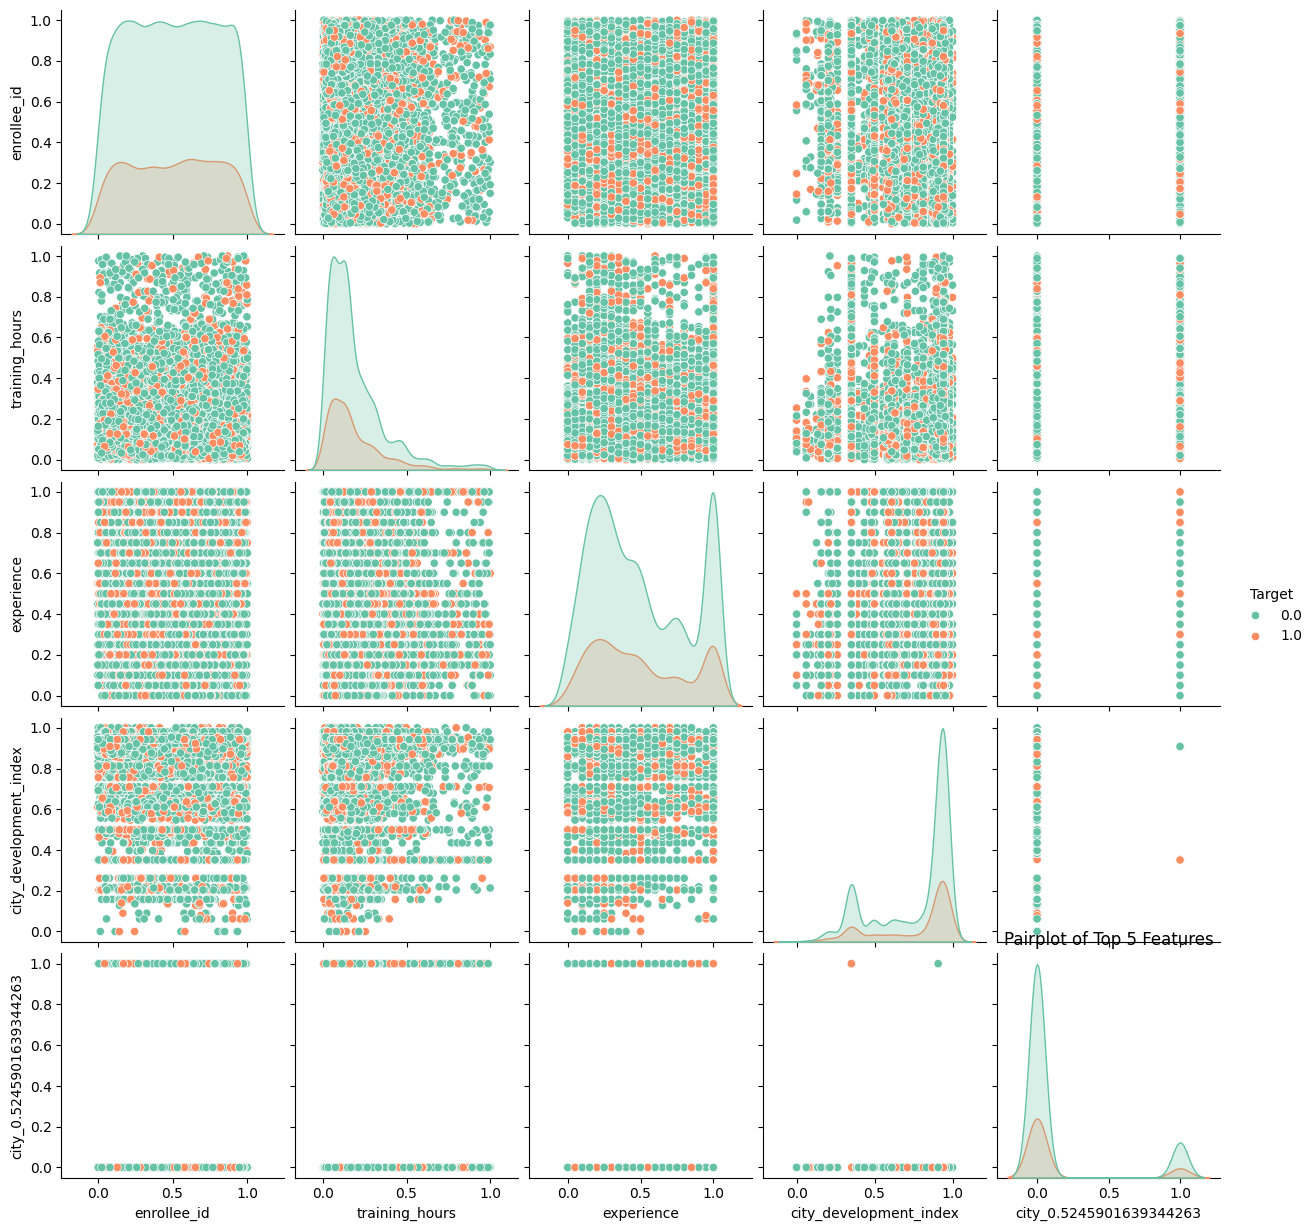

In [73]:
# Example: Pairplot for top 5 features
top_features = feature_importance_df['Feature'].head(5).tolist()
sns.pairplot(pd.concat([X_train[top_features], pd.Series(y_train, name='Target')], axis=1), hue='Target', palette='Set2')
plt.title('Pairplot of Top 5 Features')
plt.show()

**Summary of Insights from the Dataset and Visualization**
<p>After analyzing the dataset through various machine learning models and visualizations, we have gained key insights into the factors influencing job-seeking success. Here’s what we have learned:</p>

**Feature Importance:**

<p>Certain factors like experience, training hours, and city development index significantly impact job-seeking success.
Company size and type also play a role in hiring patterns.</p>

**Class Distribution & Correlation:**

<p>There is an imbalance in the dataset, meaning some job-seeking groups are overrepresented.
The correlation heatmap helped identify dependencies between variables, guiding feature selection.</p>

**Model Performance:**

<p>Random Forest and XGBoost performed best, showing higher accuracy and reliability.
CNN had lower accuracy, indicating that deep learning might not be the best fit for this dataset.
Logistic Regression was efficient but less accurate compared to tree-based models.</p>

**Learning Curves & Overfitting Analysis:**

<p>Some models like Decision Trees overfitted on training data, while others like Logistic Regression had stable performance across training and validation.</p>

**Predicted Probabilities & Class Separation:**

<p>The distribution of predicted probabilities showed that some job-seekers have a much higher likelihood of success than others, reinforcing the importance of tailored training programs.</p>


<h1>Final Takeaway for Stakeholder Alex Wagner</h1>
<p>As a Job Market Analyst, Alex Wagner can now make data-driven decisions on hiring trends and skill demands.</p>
<p>The analysis confirms that experience, targeted training, and company factors are critical for job-seeking success.</p>
<p>With this knowledge, Alex can develop recruitment strategies, optimize hiring pipelines,</p>
<p>and guide job-seekers towards in-demand skills to improve their employability in the competitive job market.</p>







